# 遺伝的アルゴリズム

このノートブックは[AI for Beginners Curriculum](http://github.com/microsoft/ai-for-beginners)の一部です。


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## 理論の概要

**遺伝的アルゴリズム** (GA) は、AIにおける**進化的アプローチ**に基づいており、集団の進化の方法を用いて、与えられた問題の最適解を得る手法です。1975年に[ジョン・ヘンリー・ホランド](https://en.wikipedia.org/wiki/John_Henry_Holland)によって提案されました。

遺伝的アルゴリズムは以下の考え方に基づいています：
* 問題の有効な解は**遺伝子**として表現できる
* **交叉**により、2つの解を組み合わせて新しい有効な解を得ることができる
* **選択**は、ある**適応度関数**を用いて、より最適な解を選び出すために使用される
* **突然変異**を導入することで、最適化を不安定化させ、局所的な最小値から抜け出すことができる

遺伝的アルゴリズムを実装するには、以下が必要です：

 * 問題の解を**遺伝子** $g\in\Gamma$ を用いて符号化する方法を見つける
 * 遺伝子の集合 $\Gamma$ 上で**適応度関数** $\mathrm{fit}: \Gamma\to\mathbb{R}$ を定義する。関数値が小さいほど、より良い解を意味する。
 * 2つの遺伝子を組み合わせて新しい有効な解を得るための**交叉**メカニズム $\mathrm{crossover}: \Gamma^2\to\Gamma$ を定義する。
 * **突然変異**メカニズム $\mathrm{mutate}: \Gamma\to\Gamma$ を定義する。
多くの場合、交叉と突然変異は、遺伝子を数列やビットベクトルとして操作する単純なアルゴリズムです。

遺伝的アルゴリズムの具体的な実装はケースごとに異なりますが、全体的な構造は以下の通りです：

1. 初期集団 $G\subset\Gamma$ を選択する
2. このステップで実行する操作（交叉または突然変異）をランダムに選択する
3. **交叉**:
  * ランダムに2つの遺伝子 $g_1, g_2 \in G$ を選択する
  * 交叉を計算する $g=\mathrm{crossover}(g_1,g_2)$
  * $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ または $\mathrm{fit}(g)<\mathrm{fit}(g_2)$ の場合、対応する遺伝子を $g$ に置き換える
4. **突然変異** - ランダムに遺伝子 $g\in G$ を選択し、それを $\mathrm{mutate}(g)$ に置き換える
5. ステップ2に戻り、$\mathrm{fit}$ の値が十分小さくなるか、ステップ数の制限に達するまで繰り返す

遺伝的アルゴリズムで一般的に解決される課題：
1. スケジュールの最適化
1. 最適なパッキング
1. 最適な切断
1. 全探索の高速化


## 問題 1: 公平な宝物の分配

**課題**:  
2人が宝物を見つけました。その宝物には異なるサイズ（それに応じて異なる価格）のダイヤモンドが含まれています。彼らは宝物を2つの部分に分け、価格の差が0（または最小）になるようにする必要があります。

**正式な定義**:  
数値の集合 $S$ が与えられています。この集合を2つの部分集合 $S_1$ と $S_2$ に分割し、以下を満たすようにします。  
$$\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$$  
また、$S_1\cup S_2=S$, $S_1\cap S_2=\emptyset$ であること。

まず、集合 $S$ を定義しましょう:


In [3]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[8344 2197 9335 3131 5863 9429 3818 9791   15 5455 1396 9538 4872 6549
 8587 5986 6021 9764 8102 5083 5739 7684 8498 3007 6599  820 7490 2372
 9370 5235 3525 3154  859 1906 8159 3950 2173 2988 2050  349 8713 2284
 4177 6033 1651 9176 5049 8201  171 5081 1216 3756 4711 2757 7738 1272
 5650 6584 5395 9004 7797  969 8104 1283 1392 4001 5768  445  274  256
 8239 8015 4381 9021 1189 8879 1411 3539 6526 8011  136 7230 2332  451
 5702 2989 4320 2446 9578 8486 4027 2410 9588 8981 2177 1493 3232 9151
 4835 5594 6859 8394  369 3200  126 4259 2283 7755 2014 2458 8327 8082
 7413 7622 1206 5533 8751 3495 5868 8472 6850 3958 3149 4672 4810 6274
 4700 6134 4627 4616 6656 9949  884 2256 7419 1926 7973 5319 5967 9158
 3823 7697 9466 5675 5412 9784 5426 8209 3421 1136 6047 4429 8001 4417
 1381  722 7350 6018 6235 7860 5853 7660 5937 6242    1 9552 3971 8302
 2633 9227 7283  154 8599 4269 9392 8539 1630  368 2409 9351 3838 9814
 6186 5743 5083 1325 1610  779 3643 3262 5768 8725  961 4611 6310 4788
 1648 

問題の各可能な解を、バイナリベクトル $B\in\{0,1\}^N$ によって符号化しましょう。ここで、元の集合 $S$ の $i$ 番目の数値がどの集合 ($S_1$ または $S_2$) に属するかを、$i$ 番目の位置の数値が示します。`generate` 関数はこれらのランダムなバイナリベクトルを生成します。


In [5]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0]


では、解の「コスト」を計算する`fit`関数を定義しましょう。それは2つの集合、$S_1$と$S_2$の合計の差になります。


In [6]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

133784

突然変異と交叉のための関数を定義する必要があります：
* 突然変異では、ランダムに1つのビットを選択し、それを反転させます（0を1に、またはその逆に変更します）。
* 交叉では、1つのベクトルからいくつかのビットを取り、もう1つのベクトルから別のビットを取ります。どの入力マスクからどのビットを取るかをランダムに選択するために、同じ`generate`関数を使用します。


In [7]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

解の初期集団 $P$ をサイズ `pop_size` で作成しましょう。


In [8]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

進化を実行する主な関数です。`n` は進化を行うステップ数を表します。各ステップで以下を行います：
* 30%の確率で突然変異を実行し、最も悪い `fit` 関数を持つ要素を突然変異した要素で置き換えます
* 70%の確率で交叉を実行します

この関数は最良の解（最良の解に対応する遺伝子）と、各イテレーションで集団内の最小の `fit` 関数の履歴を返します。


In [9]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0
 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1] 4


全体の人口に対する`fit`関数がプロセス中にどのように振る舞うかを示すグラフがこちらです！`fit`関数をかなり最小化することに成功したことがわかります。


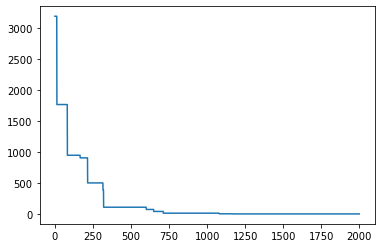

In [10]:
plt.plot(hist)
plt.show()

## 問題 2: N クイーン問題

**課題**:  
$N$×$N$ サイズのチェス盤に $N$ 個のクイーンを配置し、互いに攻撃し合わないようにする必要があります。

まず、遺伝的アルゴリズムを使わずに、全探索を用いてこの問題を解いてみましょう。チェス盤の状態はリスト $L$ で表現できます。このリストの $i$ 番目の数値は、$i$ 行目におけるクイーンの水平位置を示します。明らかなこととして、各解では各行に1つのクイーンしか存在せず、各行には必ずクイーンが配置されます。

私たちの目標は、この問題の最初の解を見つけることであり、その後探索を停止します。この関数を簡単に拡張することで、クイーンのすべての可能な配置を生成することもできます。


In [11]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False
            
nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

では、20クイーン問題の解決にどれくらい時間がかかるか測定してみましょう。


In [12]:
%timeit nqueens([],20,False)

10.6 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


では、同じ問題を遺伝的アルゴリズムを使って解いてみましょう。この解法は[このブログ記事](https://kushalvyas.github.io/gen_8Q.html)に触発されています。

各解を長さ$N$の同じリストで表現し、`fit`関数としては互いに攻撃し合うクイーンの数を取ります：


In [13]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

フィットネス関数の計算には時間がかかるため、各解をフィットネス関数の値とともに集団に保存しましょう。初期集団を生成しましょう。


In [14]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([2, 3, 8, 7, 5, 4, 1, 6]), 4),
 (array([3, 4, 5, 1, 2, 8, 6, 7]), 8),
 (array([1, 3, 7, 4, 5, 8, 6, 2]), 6),
 (array([1, 5, 4, 6, 8, 3, 7, 2]), 4),
 (array([3, 5, 7, 1, 8, 6, 4, 2]), 3)]

突然変異と交叉の関数を定義する必要があります。交叉は、ランダムなポイントで2つの遺伝子を分割し、異なる遺伝子の2つの部分を結合することで2つの遺伝子を組み合わせます。


In [15]:
def mutate(G):
    x=random.randint(0,len(G)-1)
    G[x]=random.randint(1,len(G))
    return G
    
def xover(G1,G2):
    x=random.randint(0,len(G1))
    return np.concatenate((G1[:x],G2[x:]))

xover([1,2,3,4],[5,6,7,8])

array([1, 2, 7, 8])

In [17]:
def choose_rand(P):
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

進化のメインループを定義しましょう。今回は、前回の例とは少し異なるロジックを使い、創造的なアプローチが可能であることを示します。完璧な解決策（適応度関数=0）を得るまでループを続けます。各ステップでは現在の世代を取り、同じサイズの新しい世代を生成します。これは、以下の手順を用いて `nxgeneration` 関数で行います。

1. 最も適応度の低い解決策を除外する - これを行う `discard_unfit` 関数があります
1. 世代にいくつかのランダムな解決策を追加する
1. 新しい世代を `gen_size` のサイズで生成する。各新しい遺伝子について以下の手順を実行します：
    - 適応度関数に比例した確率で、ランダムに2つの遺伝子を選択する
    - 交叉を計算する
    - 確率 `mutation_prob` で突然変異を適用する


In [20]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n=mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
        '''
        if (nf<=P[p1][1]) or (nf<=P[p2][1]):
            new_gen.append((n,nf))
        elif (P[p1][1]<P[p2][1]):
            new_gen.append(P[p1])
        else:
            new_gen.append(P[p2])
        '''
    return new_gen
    
def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        #print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

(array([4, 7, 5, 3, 1, 6, 8, 2]), 0)

ほとんどの場合、私たちは比較的迅速に解決策を見つけることができるのは興味深いことですが、まれなケースでは最適化が局所的な最小値に達し、プロセスが長時間停滞することがあります。平均時間を測定する際にはそれを考慮することが重要です。ほとんどの場合、遺伝的アルゴリズムは完全探索よりも速いですが、場合によっては時間がかかることがあります。この問題を克服するために、考慮する世代数を制限することが理にかなっている場合があり、解決策を見つけることができない場合は、最初からやり直すことができます。


In [19]:
%timeit genetic(10)

The slowest run took 18.71 times longer than the fastest. This could mean that an intermediate result is being cached.
26.4 s ± 28.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



---

**免責事項**:  
この文書は、AI翻訳サービス [Co-op Translator](https://github.com/Azure/co-op-translator) を使用して翻訳されています。正確性を追求しておりますが、自動翻訳には誤りや不正確な部分が含まれる可能性があります。元の言語で記載された文書を正式な情報源としてご参照ください。重要な情報については、専門の人間による翻訳を推奨します。この翻訳の使用に起因する誤解や誤解釈について、当方は責任を負いません。
